Solving Twitter Real Disaster or Not?

**Problem statement**: Predict whether the tweet represent real disaster or not given the text of tweet

**Type**: Binary Classification (1: real disaster; 0: not disaster)

**Performance metric**: Harmonic balance of precision and recall, F1 score.

**What I did in this notebook**:
**Comparing three vectorizations** that could be implemented using scikit-learn:
1. Count Vectorization
2. TF-IDF Vectorization
3. Hashing Vectorization -> Binary Vectorization

**Experimenting with several models**:
1. Logistic Regression
2. Multi Layer Perceptron

**Conclusion**:
1. **CountVectorizer with adjusted hyperparameter** (ngram_range, and max_features) fed to **Logistic Regression** perform the best compare to any variants I tried. It gives F1-score on validation data 0.7529.


In [1]:
# Library
import pandas as pd
import numpy as np
import spacy
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import chi2

import tensorflow as tf
from tensorflow import keras
import keras.backend as K

import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.


In [2]:
# Read file
train = pd.read_csv("/kaggle/input/nlp-getting-started/train.csv")
test = pd.read_csv("/kaggle/input/nlp-getting-started/test.csv")
sample_submission = pd.read_csv("/kaggle/input/nlp-getting-started/sample_submission.csv")

In [3]:
# See number of samples per label
samples = train[['text', 'target']].groupby("target").count().reset_index()
samples['total'] = samples.text.sum()
samples['proportion'] = samples.text / samples.total
samples

# This dataset is not an imbalance dataset

,target,text,total,proportion
0,0,4342,7613,0.57034
1,1,3271,7613,0.42966


In [4]:
# Count words / token in sample text
def len_token(x):
    return len(x.split())

train['num_words'] = train.text.apply(lambda x: len_token(x))

count    7613.000000
mean       14.903586
std         5.732604
min         1.000000
25%        11.000000
50%        15.000000
75%        19.000000
max        31.000000
Name: num_words, dtype: float64

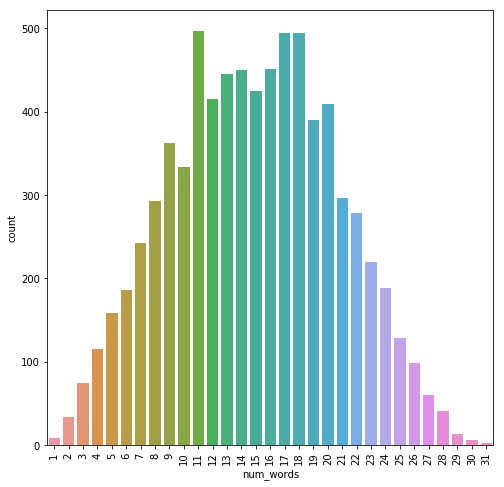

In [5]:
# See number of words per samples
plt.figure(figsize=(8,8))
sns.countplot(x = train['num_words'])
plt.xticks(rotation=90)

train['num_words'].describe()
# The average of num_words in samples is 17.7 words
# and the 3rd quatile is 23

num_words                                                  
           count       mean       std  min   25%   50%   75%   max
target                                                            
0         4342.0  14.704744  6.161564  1.0  10.0  15.0  19.0  31.0
1         3271.0  15.167533  5.096806  2.0  11.0  15.0  19.0  30.0

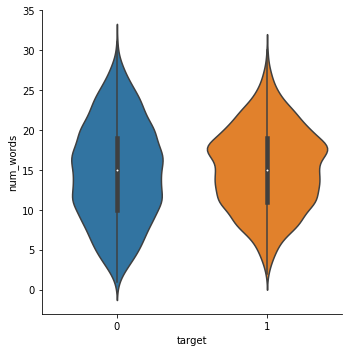

In [6]:
# Difference on distribution num_words on label 1 and 0
sns.catplot(x='target', y = 'num_words', kind = 'violin', data=train )
train[['num_words', 'target']].groupby('target').describe()

# Label 0 tend to have higher num_words showed in 3rd quartile and its higher std compare to label 1

In [7]:
# Get ratio of samples per number of word per samples
train['num_words'].count() / (train['num_words'].sum() / train['num_words'].count())

# The dataset have ratio (samples) per (number of word per samples) = 510 < 1500
# Based on this post https://developers.google.com/machine-learning/guides/text-classification/step-2-5
# The n-gram model would be better and perform well, we don't have to use sequence model yet

510.8166594688924

In [8]:
# Split train and validation dataset
X_train, X_val, y_train, y_val = train_test_split(train, train.target,
                                                    test_size=0.1, random_state=1)

X_train.shape, X_val.shape, y_train.shape, y_val.shape

((6851, 6), (762, 6), (6851,), (762,))

In [9]:
# See number of samples per label on the training dataset
# The samples has the same proportion with the whole training data
samples = y_train.value_counts().reset_index()
samples['total'] = samples.target.sum()
samples['proportion'] = samples.target / samples.total
samples

,index,target,total,proportion
0,0,3904,6851,0.569844
1,1,2947,6851,0.430156


### Baseline Model (Count Vectorizer)

In [10]:
# Fit CountVectorizer and see the vocabulary
vectorizer = CountVectorizer()
vectorizer.fit(X_train['text'])
# vectorizer.vocabulary_

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

In [11]:
# Create vector from Count Vecorizer
train_vector = vectorizer.transform(X_train['text']) 
val_vector = vectorizer.transform(X_val['text'])

In [12]:
# Build simple model using Logistic Regression
logreg = LogisticRegression()

logreg.fit(train_vector, y_train)
y_pred = logreg.predict(val_vector)

score = f1_score(y_val, y_pred)
print("F1 Score Baseline model on validation dataset: {}".format(score))

# 0.735 is our baseline score

F1 Score Baseline model on validation dataset: 0.7354409317803662


In [13]:
# Train model on all training data
# Test using test dataset
logreg = LogisticRegression()

train_vector = vectorizer.transform(train['text'])
test_vector = vectorizer.transform(test['text'])

logreg.fit(train_vector, train.target)
y_pred = logreg.predict(test_vector)

In [14]:
# Submission using baseline model
submission_baseline = pd.read_csv('/kaggle/input/nlp-getting-started/sample_submission.csv')
submission_baseline['target'] = y_pred
submission_baseline.to_csv('baseline_logreg.csv', index=False)

### TF-IDF Vectorizer

In [15]:
# Previously we are using CountVectorizer which using count of each word to generate vector representation of each instance.
# Now we are using TF-IDF Vectorizer to generate vector representation of the instances.
# The difference is TF-IDF will consider word Frequency and also Inverse Document (that the word appear on)Frequency
# The implementation is using sklearn

# Create vectorizer and fit with training data
tfidfvectorizer = TfidfVectorizer(ngram_range= (1,4), max_features=4000)
tfidfvectorizer.fit(X_train['text'])

# Create vector of train and validation data using tfidf
train_vector = tfidfvectorizer.transform(X_train['text'])
val_vector = tfidfvectorizer.transform(X_val['text'])

# Build simple model using LogisticRegression
logreg = LogisticRegression()
logreg.fit(train_vector, y_train)
y_pred = logreg.predict(val_vector)

score = f1_score(y_val, y_pred)
print("F1 Score LogReg using TF-IDF on validation dataset: {}".format(score))
# The LogReg with TF-IDF with adjusted hyperparameter perform better than baseline model. Its f1 score is 0.7466

F1 Score LogReg using TF-IDF on validation dataset: 0.7466216216216216


In [16]:
# Train model on all training data
# Test using test dataset

# Create vectorizer and fit with training data
tfidfvectorizer = TfidfVectorizer(ngram_range= (1,4), max_features=4000)
tfidfvectorizer.fit(train['text'])

train_vector = tfidfvectorizer.transform(train['text'])
test_vector = tfidfvectorizer.transform(test['text'])

logreg = LogisticRegression()

logreg.fit(train_vector, train.target)
y_pred = logreg.predict(test_vector)

In [17]:
# Submission using baseline model
submission_tfidf = pd.read_csv('/kaggle/input/nlp-getting-started/sample_submission.csv')
submission_tfidf['target'] = y_pred
submission_tfidf.to_csv('tfidf_logreg.csv', index=False)

### Hashing Vectorizer to get Binary Vectorization

In [18]:
# Create vectorizer and fit with training data
vectorizer = HashingVectorizer(binary= True)
vectorizer.fit(X_train['text'])

# Create vector of train and validation data using tfidf
train_vector = vectorizer.transform(X_train['text'])
val_vector = vectorizer.transform(X_val['text'])

# Build simple model using LogisticRegression
logreg = LogisticRegression()
logreg.fit(train_vector, y_train)
y_pred = logreg.predict(val_vector)

score = f1_score(y_val, y_pred)
print("F1 Score LogReg using HashingVectorizer on validation dataset: {}".format(score))
# The Binary Vectorizer perform better than Count Vectorizer, but not TF-IDF Vectorizer
# The F1 Score is 0.74

F1 Score LogReg using HashingVectorizer on validation dataset: 0.7401032702237521


In [19]:
# Train model on all training data
# Test using test dataset

# Create vectorizer and fit with training data
vectorizer = HashingVectorizer(binary= True)
vectorizer.fit(train['text'])

train_vector = vectorizer.transform(train['text'])
test_vector = vectorizer.transform(test['text'])

logreg = LogisticRegression()

logreg.fit(train_vector, train.target)
y_pred = logreg.predict(test_vector)

In [20]:
# Submission using binary vectorizer
submission_binary = pd.read_csv('/kaggle/input/nlp-getting-started/sample_submission.csv')
submission_binary['target'] = y_pred
submission_binary.to_csv('binary_vect_logreg.csv', index=False)

### Count Vectorizer with adjusted hyperparameter

In [21]:
# Create vectorizer and fit with training data
tfidfvectorizer = CountVectorizer(ngram_range= (1,4), max_features=4000)
tfidfvectorizer.fit(X_train['text'])

# Create vector of train and validation data using tfidf
train_vector = tfidfvectorizer.transform(X_train['text'])
val_vector = tfidfvectorizer.transform(X_val['text'])

# Build simple model using LogisticRegression
logreg = LogisticRegression()
logreg.fit(train_vector, y_train)
y_pred = logreg.predict(val_vector)

score = f1_score(y_val, y_pred)
print("F1 Score LogReg using CountVectorizer with adjusted hyperparameter on validation dataset: {}".format(score))
# These adjusted hyperparameter help CountVectorizer to perform better. its f1 score is 0.7529

F1 Score LogReg using CountVectorizer with adjusted hyperparameter on validation dataset: 0.7529021558872305


In [22]:
# Train model on all training data
# Test using test dataset

# Create vectorizer and fit with training data
vectorizer = CountVectorizer(ngram_range= (1,4), max_features=4000)
vectorizer.fit(train['text'])

train_vector = vectorizer.transform(train['text'])
test_vector = vectorizer.transform(test['text'])

logreg = LogisticRegression()

logreg.fit(train_vector, train.target)
y_pred = logreg.predict(test_vector)

In [23]:
# Submission using count vectorizer with adjusted hyperparameter
submission_better_count = pd.read_csv('/kaggle/input/nlp-getting-started/sample_submission.csv')
submission_better_count['target'] = y_pred
submission_better_count.to_csv('better_count_logreg.csv', index=False)

### Count Vectorizer with adjusted hyperparameter + Normalize features

In [24]:
# Create vectorizer and fit with training data
tfidfvectorizer = CountVectorizer(ngram_range= (1,4), max_features=4000)
tfidfvectorizer.fit(X_train['text'])

# Create vector of train and validation data using tfidf
train_vector = tfidfvectorizer.transform(X_train['text'])
val_vector = tfidfvectorizer.transform(X_val['text'])

# Standadize features
scaler = Normalizer()
scaler.fit(train_vector)

train_vector = scaler.transform(train_vector)
val_vector = scaler.transform(val_vector)

# Build simple model using LogisticRegression
logreg = LogisticRegression()
logreg.fit(train_vector, y_train)
y_pred = logreg.predict(val_vector)

score = f1_score(y_val, y_pred)
print("F1 Score LogReg using CountVectorizer with adjusted hyperparameter on validation dataset: {}".format(score))
# These adjusted hyperparameter help CountVectorizer and Normalize did not perform better. its f1 score is 0.728

F1 Score LogReg using CountVectorizer with adjusted hyperparameter on validation dataset: 0.7288135593220338


### Multi Layer Perceptron + (Count Vectorizer / TF-IDF Vectorizer)

In [25]:
# Now we have two possible vectorizer, we will try using difference modelling which is MLP
# We will use shallow MLP first to see whether the model will perform better or not than Logistic Regression

# MLP with Count Vectorizer

# Create vectorizer and fit with training data
vectorizer = CountVectorizer(ngram_range= (1,2), max_features=4000)
vectorizer.fit(X_train['text'])

# Create vector of train and validation data using tfidf
train_count_vector = vectorizer.transform(X_train['text'])
val_count_vector = vectorizer.transform(X_val['text'])

# MLP Architecture
mlp_count = keras.Sequential([
    keras.layers.Dense(1028, activation= 'relu', kernel_initializer= 'he_normal', input_shape=train_count_vector.shape[1:]),
    keras.layers.Dense(256, activation= 'relu', kernel_initializer= 'he_normal'),
    keras.layers.Dense(1, activation='sigmoid')
])

# Compile MLP
mlp_count.compile(optimizer= 'adam',
                  loss= 'binary_crossentropy',
                  metrics= ['accuracy']
                 )

# Train MLP
mlp_count.fit(train_count_vector.toarray(), y_train, epochs=10)

Train on 6851 samples
Epoch 1/10
6851/6851 [==============================] - 2s 310us/sample - loss: 0.4946 - accuracy: 0.7762
Epoch 2/10
6851/6851 [==============================] - 1s 111us/sample - loss: 0.2884 - accuracy: 0.8867
Epoch 3/10
6851/6851 [==============================] - 1s 113us/sample - loss: 0.1481 - accuracy: 0.9464
Epoch 4/10
6851/6851 [==============================] - 1s 113us/sample - loss: 0.0822 - accuracy: 0.9698
Epoch 5/10
6851/6851 [==============================] - 1s 117us/sample - loss: 0.0586 - accuracy: 0.9731
Epoch 6/10
6851/6851 [==============================] - 1s 113us/sample - loss: 0.0527 - accuracy: 0.9778
Epoch 7/10
6851/6851 [==============================] - 1s 125us/sample - loss: 0.0465 - accuracy: 0.9788
Epoch 8/10
6851/6851 [==============================] - 1s 118us/sample - loss: 0.0422 - accuracy: 0.9801
Epoch 9/10
6851/6851 [==============================] - 1s 110us/sample - loss: 0.0400 - accuracy: 0.9804
Epoch 10/10
6851/6851 [=

In [26]:
# Evaluate model in validation dataset
test_loss, test_acc = mlp_count.evaluate(val_count_vector.toarray(),y_val, verbose= 0)
print("MLP Accuracy on Validation: {}".format(test_acc))

# Evaluate model in validation dataset
y_pred = mlp_count.predict_classes(val_count_vector.toarray())
score = f1_score(y_val, y_pred)
print("F1 Score MLP and Count Vectorizer on validation dataset: {}".format(score))

MLP Accuracy on Validation: 0.7939632534980774
F1 Score MLP and Count Vectorizer on validation dataset: 0.7279029462738302


In [27]:
# Train model on all training data
# Test using test dataset

# Create vectorizer and fit with training data
vectorizer = CountVectorizer(ngram_range= (1,2), max_features=4000)
vectorizer.fit(train['text'])

train_vector = vectorizer.transform(train['text'])
test_vector = vectorizer.transform(test['text'])

# MLP Architecture
mlp_count = keras.Sequential([
    keras.layers.Dense(1028, activation= 'relu', kernel_initializer= 'he_normal', input_shape=train_count_vector.shape[1:]),
    keras.layers.Dense(256, activation= 'relu', kernel_initializer= 'he_normal'),
    keras.layers.Dense(1, activation='sigmoid')
])

# Compile MLP
mlp_count.compile(optimizer= 'adam',
                  loss= 'binary_crossentropy',
                  metrics= ['accuracy']
                 )

# Train MLP
mlp_count.fit(train_vector.toarray(), train.target, epochs=20, verbose=0)

# Prediction on test dataset
y_pred = mlp_count.predict_classes(test_vector.toarray())

# Submission using MLP and count vectorizer
submission_mlp_count = pd.read_csv('/kaggle/input/nlp-getting-started/sample_submission.csv')
submission_mlp_count['target'] = y_pred
submission_mlp_count.to_csv('count_mlp.csv', index=False)

In [28]:
# MLP with TF-IDF Vectorizer

# Create vectorizer and fit with training data
tfidfvectorizer = TfidfVectorizer(ngram_range= (1,2), max_features=4000)
tfidfvectorizer.fit(X_train['text'])

# Create vector of train and validation data using tfidf
train_tfidf_vector = tfidfvectorizer.transform(X_train['text'])
val_tfidf_vector = tfidfvectorizer.transform(X_val['text'])

# MLP Architecture
mlp_tfidf = keras.Sequential([
    keras.layers.Dense(1028, activation= 'relu', kernel_initializer= 'he_normal', input_shape=train_tfidf_vector.shape[1:]),
    keras.layers.Dense(256, activation= 'relu', kernel_initializer= 'he_normal'),
    keras.layers.Dense(1, activation='sigmoid')
])

# Compile MLP
mlp_tfidf.compile(optimizer= 'adam',
                  loss= 'binary_crossentropy',
                  metrics= ['accuracy']
                 )

# Train MLP
mlp_tfidf.fit(train_tfidf_vector.toarray(), y_train, epochs=10)

Train on 6851 samples
Epoch 1/10
6851/6851 [==============================] - 1s 170us/sample - loss: 0.4979 - accuracy: 0.7581
Epoch 2/10
6851/6851 [==============================] - 1s 116us/sample - loss: 0.2955 - accuracy: 0.8780
Epoch 3/10
6851/6851 [==============================] - 1s 118us/sample - loss: 0.1638 - accuracy: 0.9399
Epoch 4/10
6851/6851 [==============================] - 1s 118us/sample - loss: 0.0886 - accuracy: 0.9691
Epoch 5/10
6851/6851 [==============================] - 1s 115us/sample - loss: 0.0614 - accuracy: 0.9749
Epoch 6/10
6851/6851 [==============================] - 1s 117us/sample - loss: 0.0503 - accuracy: 0.9788
Epoch 7/10
6851/6851 [==============================] - 1s 115us/sample - loss: 0.0447 - accuracy: 0.9787
Epoch 8/10
6851/6851 [==============================] - 1s 112us/sample - loss: 0.0411 - accuracy: 0.9806
Epoch 9/10
6851/6851 [==============================] - 1s 114us/sample - loss: 0.0391 - accuracy: 0.9807
Epoch 10/10
6851/6851 [=

In [29]:
# Evaluate model in validation dataset
test_loss, test_acc = mlp_tfidf.evaluate(val_count_vector.toarray(),y_val, verbose= 0)
print("MLP Accuracy on Validation: {}".format(test_acc))

# Evaluate model in validation dataset
y_pred = mlp_tfidf.predict_classes(val_count_vector.toarray())
score = f1_score(y_val, y_pred)
print("F1 Score MLP and TF-IDF Vectorizer on validation dataset: {}".format(score))

MLP Accuracy on Validation: 0.7677165269851685
F1 Score MLP and TF-IDF Vectorizer on validation dataset: 0.7354260089686099


In [30]:
# Train model on all training data
# Test using test dataset

# Create vectorizer and fit with training data
tfidfvectorizer = TfidfVectorizer(ngram_range= (1,2), max_features=4000)
vectorizer.fit(train['text'])

train_vector = vectorizer.transform(train['text'])
test_vector = vectorizer.transform(test['text'])

# MLP Architecture
mlp_tfidf = keras.Sequential([
    keras.layers.Dense(1028, activation= 'relu', kernel_initializer= 'he_normal', input_shape=train_vector.shape[1:]),
    keras.layers.Dense(256, activation= 'relu', kernel_initializer= 'he_normal'),
    keras.layers.Dense(1, activation='sigmoid')
])

# Compile MLP
mlp_tfidf.compile(optimizer= 'adam',
                  loss= 'binary_crossentropy',
                  metrics= ['accuracy']
                 )

# Train MLP
mlp_tfidf.fit(train_vector.toarray(), train.target, epochs=10, verbose=0)

# Prediction on test dataset
y_pred = mlp_tfidf.predict_classes(test_vector.toarray())

# Submission using MLP and count vectorizer
submission_mlp_tfidf = pd.read_csv('/kaggle/input/nlp-getting-started/sample_submission.csv')
submission_mlp_tfidf['target'] = y_pred
submission_mlp_tfidf.to_csv('tfidf_mlp.csv', index=False)

### EDA
Since we have been benchmarking several models and found that the Logistic Regression perform better than MLP.
I believe we need to take a look deeper into the data.

In [31]:
# First we want to see whether eliminating stopwords will increase the model performance
stop_words = list(ENGLISH_STOP_WORDS)

NameError: name 'ENGLISH_STOP_WORDS' is not defined

In [32]:
# Create vectorizer and fit with training data
vectorizer = CountVectorizer(ngram_range= (1,4), max_features = 4000, stop_words = stop_words)
vectorizer.fit(X_train['text'])

# Create vector of train and validation data using tfidf
train_vector = vectorizer.transform(X_train['text'])
val_vector = vectorizer.transform(X_val['text'])

# Build simple model using LogisticRegression
logreg = LogisticRegression()
logreg.fit(train_vector, y_train)
y_pred = logreg.predict(val_vector)

score = f1_score(y_val, y_pred)
print("F1 Score LogReg using Count Vectorizer with Stop Words on validation dataset: {}".format(score))
# Giving stop words worsen the model performance on F1 score

NameError: name 'stop_words' is not defined

In [33]:
# Get the models coefficients (and top 20 and bottom 20)
def plot_top_bottom_20_coef(model, feature_names):
    logReg_coeff = pd.DataFrame({'feature_name': feature_names, 'model_coefficient': model.coef_.transpose().flatten()})
    logReg_coeff = logReg_coeff.sort_values('model_coefficient',ascending=False)
    logReg_coeff_top = logReg_coeff.head(20)
    logReg_coeff_bottom = logReg_coeff.tail(20)

    plt.figure().set_size_inches(10, 6)
    fg3 = sns.barplot(x='feature_name', y='model_coefficient',data=logReg_coeff_top, palette="Blues_d")
    fg3.set_xticklabels(rotation=35, labels=logReg_coeff_top.feature_name)
    # Plot bottom 5 coefficients
    plt.figure().set_size_inches(10,6)
    fg4 = sns.barplot(x='feature_name', y='model_coefficient',data=logReg_coeff_bottom, palette="GnBu_d")
    fg4.set_xticklabels(rotation=35, labels=logReg_coeff_bottom.feature_name)
    plt.xlabel('Feature')
    plt.ylabel('Coefficient')
    plt.subplots_adjust(bottom=0.4)

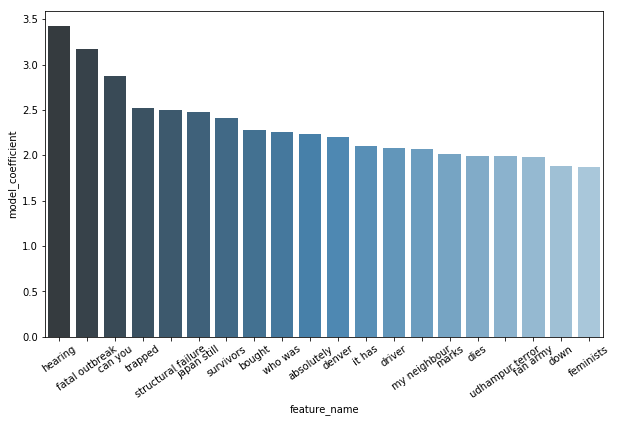

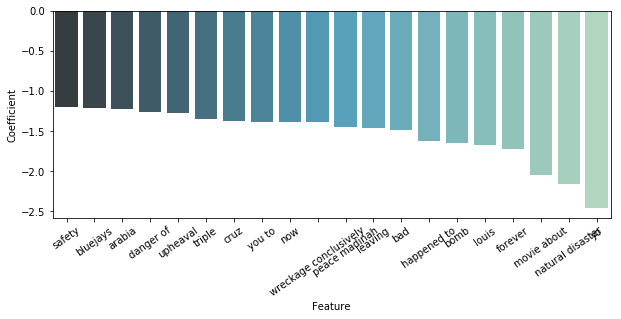

In [34]:
# Plot logistic regression coefficient on using Count Vectorizer
# get feature names
feature_names = np.array(vectorizer.get_feature_names())
plot_top_bottom_20_coef(logreg, feature_names)

In [35]:
# See coefficient Logistic Regression on TF-IDF Vectorizer

# Create vectorizer and fit with training data
tfidfvectorizer = TfidfVectorizer(ngram_range= (1,4), max_features=4000)
tfidfvectorizer.fit(X_train['text'])

# Create vector of train and validation data using tfidf
train_vector = tfidfvectorizer.transform(X_train['text'])
val_vector = tfidfvectorizer.transform(X_val['text'])

# Build simple model using LogisticRegression
logreg = LogisticRegression()
logreg.fit(train_vector, y_train)
y_pred = logreg.predict(val_vector)

score = f1_score(y_val, y_pred)
print("F1 Score LogReg using TF-IDF on validation dataset: {}".format(score))


F1 Score LogReg using TF-IDF on validation dataset: 0.7466216216216216


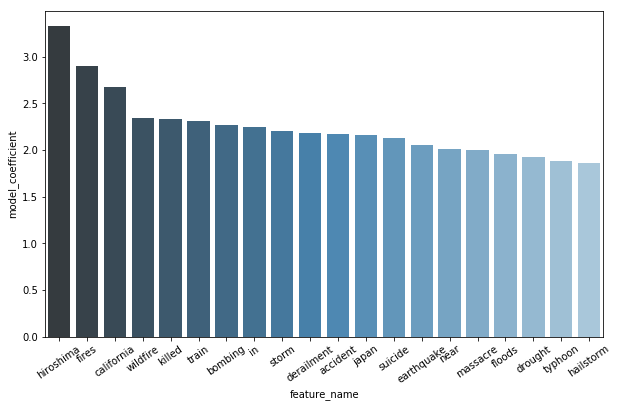

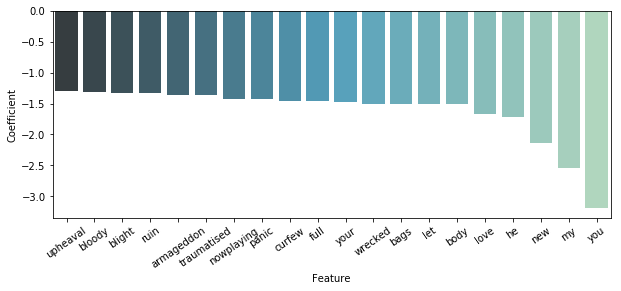

In [36]:
# Plot Coefficient TF-IDF LogReg Model

# get feature names
feature_names = np.array(tfidfvectorizer.get_feature_names())
plot_top_bottom_20_coef(logreg, feature_names)

# 20 positive coefficient features from Count Vectorizer and TF-IDF Vectorizer quite the same
# The difference is in negative coefficient. Count Vectorizer tend to have higher negative coefficient than TF-IDF
# Could we see which features that have the same correlation and drop it?

In [37]:
# Chi Square test is one of the way to see linear correlation between features to label

# Create vectorizer and fit with training data
vectorizer = CountVectorizer(ngram_range= (1,4), max_features = 4000)
vectorizer.fit(X_train['text'])

# Create vector of train and validation data using tfidf
train_vector = vectorizer.transform(X_train['text'])
val_vector = vectorizer.transform(X_val['text'])

# Convert vector to array
features = train_vector.toarray()
labels = y_train

# Get unigram and bigram the most correlated features
N = 10
features_chi2 = chi2(features, labels == labels)
indices = np.argsort(features_chi2[0])
feature_names = np.array(vectorizer.get_feature_names())[indices]
unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
print("  . Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-N:])))
print("  . Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-N:])))


  . Most correlated unigrams:
. friends
. from
. free
. front
. ft
. fuck
. fucking
. fukushima
. full
. ûó
  . Most correlated bigrams:
. full read
. from cameroon
. from flight
. from mh370
. from missing
. from my
. from water
. fukushima nuclear
. full re
. from the


### Select K Best
As Yann Claudel Notebook [here](https://www.kaggle.com/yclaudel/disaster-tweets-tfidf-selectkbest-mlp). I will try to improve using different metric "chi2" for selecting K best

#### Select K Best with Logistic Regression

In [38]:
# Create vectorizer and fit with training data
vectorizer = CountVectorizer(ngram_range= (1,2), max_features= 4000)
vectorizer.fit(X_train['text'])

# Create vector of train and validation data using tfidf
train_vector = vectorizer.transform(X_train['text'])
val_vector = vectorizer.transform(X_val['text'])

# Select K best
selector = SelectKBest(f_classif, k = 3000)
selector.fit(train_vector, y_train)

# Select vector
train_vector = selector.transform(train_vector)
val_vector = selector.transform(val_vector)

# Build simple model using LogisticRegression
logreg = LogisticRegression()
logreg.fit(train_vector, y_train)
y_pred = logreg.predict(val_vector)

score = f1_score(y_val, y_pred)
print("F1 Score LogReg using CountVectorizer and SelectKBest with f_classif on validation dataset: {}".format(score))
# Selecting 3000 with f_classif improve f1 score to 0.762
# I tried to use chi2 to select features, but it does not give difference with f_classif

F1 Score LogReg using CountVectorizer and SelectKBest with f_classif on validation dataset: 0.7625418060200668


In [39]:
# Train model on all training data
# Test using test dataset

# Create vectorizer and fit with training data
vectorizer = CountVectorizer(ngram_range= (1,2), max_features=4000)
vectorizer.fit(train['text'])

train_vector = vectorizer.transform(train['text'])
test_vector = vectorizer.transform(test['text'])

# SelectKBest using f_classif
selector = SelectKBest(f_classif, k = 3000)
selector.fit(train_vector, train.target)

# Select vector
train_vector = selector.transform(train_vector)
test_vector = selector.transform(test_vector)

logreg = LogisticRegression()

logreg.fit(train_vector, train.target)
y_pred = logreg.predict(test_vector)

# Submission using count vectorizer with adjusted hyperparameter
submission_count_selectk = pd.read_csv('/kaggle/input/nlp-getting-started/sample_submission.csv')
submission_count_selectk['target'] = y_pred
submission_count_selectk.to_csv('count_selectk_logreg.csv', index=False)

#### Select K Best with MLP

In [40]:
# Previously we are optimizing the model using accuracy metric instead of f1_score
# We now will implement custom metric f1_score for optimizing the model

def f1(y_true, y_pred):
    # Count positive samples.
    c1 = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    c2 = K.sum(K.round(K.clip(y_pred, 0, 1)))
    c3 = K.sum(K.round(K.clip(y_true, 0, 1)))

    # How many selected items are relevant?
    precision = c1 / c2

    # How many relevant items are selected?
    recall = c1 / c3

    # Calculate f1_score
    f1_score = 2 * (precision * recall) / (precision + recall)
    return f1_score 

In [41]:
# MLP with Select K Best

# Create vectorizer and fit with training data
vectorizer = CountVectorizer(ngram_range= (1,2), max_features= 4000)
vectorizer.fit(X_train['text'])

# Create vector of train and validation data using tfidf
train_vector = vectorizer.transform(X_train['text'])
val_vector = vectorizer.transform(X_val['text'])

# Select K best
selector = SelectKBest(f_classif, k = 3000)
selector.fit(train_vector, y_train)

# Select vector
train_vector = selector.transform(train_vector)
val_vector = selector.transform(val_vector)

# MLP Architecture
mlp = keras.Sequential([
    keras.layers.Dropout(0.3, input_shape=train_vector.shape[1:]),
    keras.layers.Dense(64, activation= 'relu', kernel_initializer= 'he_normal', ),
    keras.layers.Dropout(0.1),
    keras.layers.Dense(1, activation='sigmoid')
])

# Compile MLP
mlp.compile(optimizer= 'adam',
                  loss= 'mse',
                  metrics= ['accuracy', f1]
                 )

# Train MLP
mlp.fit(train_vector.toarray(), y_train, epochs=20)

# Evaluate model in validation dataset
test_loss, test_acc, test_f1 = mlp.evaluate(val_vector.toarray(),y_val, verbose= 0)
print("MLP Accuracy on Validation: {}; F1 Score: {}".format(test_acc, test_f1))

# Evaluate model in validation dataset
y_pred = mlp.predict_classes(val_vector.toarray())
score = f1_score(y_val, y_pred)
print("F1 Score MLP and Count Vectorizer Select K Best on validation dataset: {}".format(score))

# With current architecture it gives better performance f1_score at 0.760

Train on 6851 samples
Epoch 1/20
6851/6851 [==============================] - 1s 179us/sample - loss: 0.1851 - accuracy: 0.7421 - f1: nan
Epoch 2/20
6851/6851 [==============================] - 1s 110us/sample - loss: 0.1334 - accuracy: 0.8178 - f1: 0.7606
Epoch 3/20
6851/6851 [==============================] - 1s 108us/sample - loss: 0.1201 - accuracy: 0.8400 - f1: 0.7923
Epoch 4/20
6851/6851 [==============================] - 1s 106us/sample - loss: 0.1110 - accuracy: 0.8495 - f1: 0.8072
Epoch 5/20
6851/6851 [==============================] - 1s 109us/sample - loss: 0.1069 - accuracy: 0.8564 - f1: 0.8164
Epoch 6/20
6851/6851 [==============================] - 1s 105us/sample - loss: 0.1016 - accuracy: 0.8634 - f1: nan
Epoch 7/20
6851/6851 [==============================] - 1s 105us/sample - loss: 0.0989 - accuracy: 0.8664 - f1: 0.8319
Epoch 8/20
6851/6851 [==============================] - 1s 106us/sample - loss: 0.0976 - accuracy: 0.8694 - f1: 0.8345
Epoch 9/20
6851/6851 [==========

In [42]:
# Train model on all training data
# Test using test dataset

# Create vectorizer and fit with training data
vectorizer = CountVectorizer(ngram_range= (1,2), max_features= 4000)
vectorizer.fit(train['text'])

# Create vector
train_vector = vectorizer.transform(train['text'])
test_vector = vectorizer.transform(test['text'])

# Select K best
selector = SelectKBest(f_classif, k = 3000)
selector.fit(train_vector, train.target)

# Select vector
train_vector = selector.transform(train_vector)
test_vector = selector.transform(test_vector)

# MLP Architecture
mlp = keras.Sequential([
    keras.layers.Dropout(0.3, input_shape=train_vector.shape[1:]),
    keras.layers.Dense(64, activation= 'relu', kernel_initializer= 'he_normal', ),
    keras.layers.Dropout(0.1),
    keras.layers.Dense(1, activation='sigmoid')
])

# Compile MLP
mlp.compile(optimizer= 'adam',
                  loss= 'mse',
                  metrics= ['accuracy']
                 )

# Train MLP
mlp.fit(train_vector.toarray(), train.target, epochs=20, verbose=0)

# Prediction on test dataset
y_pred = mlp.predict_classes(test_vector.toarray())

# Submission using MLP and count vectorizer
submission_mlp_select = pd.read_csv('/kaggle/input/nlp-getting-started/sample_submission.csv')
submission_mlp_select['target'] = y_pred
submission_mlp_select.to_csv('count_select_mlp.csv', index=False)